In [152]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import random

import math
import time

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import ScalarFormatter


In [108]:
# Define Tableau 10 Colors
tableau_colors = [
    (31, 119, 180),  # Blue
    (255, 127, 14),  # Orange
    (44, 160, 44),   # Green
    (214, 39, 40),   # Red
    (148, 103, 189), # Purple
    (140, 86, 75),   # Brown
    (227, 119, 194), # Pink
    (127, 127, 127), # Gray
    (188, 189, 34),  # Yellow
    (23, 190, 207),  # Cyan
]

# Normalize RGB values to range [0, 1]
tableau_colors = [(r / 255, g / 255, b / 255) for r, g, b in tableau_colors]

font = {'family': 'Georgia', 'color':  'black', 'weight': 'normal', 'size': 20}
title_font = {'family': 'Georgia', 'color':  'black', 'weight': 'bold', 'style': 'italic', 'size': 20}
suptitle_font = FontProperties(family='Georgia', weight='bold', size=22)
legend_font = FontProperties(family='Georgia', weight='normal', size=16)
tick_font = {'family': 'Georgia', 'size': 18}

## Single-layer Perceptron for Equivalence Logic

In [92]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_deriv(x):
    return np.exp(-x) / (1.0 + np.exp(-x)) ** 2.0
    
def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 4.0 / (np.exp(x) + np.exp(-x)) ** 2.0

In [109]:
# single-layer perceptron training
def train_perceptron(X_train, y_train, tanh_flag=1, epochs=100000, eta=1):
    costs = []
    weights = np.random.rand(X_train.shape[1]) 
    
    for epoch in range(epochs):
        net_input = np.dot(weights, X_train.T)
        if tanh_flag:
            y_pred = tanh(net_input)
            gradient_weights = 2 * np.dot((y_pred - y_train) * tanh_deriv(net_input), X_train) / len(y_train) 
        else:
            y_pred = sigmoid(net_input)
            gradient_weights = 2 * np.dot((y_pred - y_train) * sigmoid_deriv(net_input), X_train) / len(y_train) 
        cost = np.sum((y_train - y_pred) ** 2) / len(y_train)    
        weights += - eta * gradient_weights
        costs.append(cost)
    return weights, costs


In [110]:
def test_perceptron(X_test, y_test, weights, tanh_flag=1):
    net_input = np.dot(weights, X_test.T)
    if tanh_flag:
        y_pred = tanh(net_input)
    else:
        y_pred = sigmoid(net_input)
    cost = np.sum((y_test - y_pred) ** 2) / len(y_test)
    return y_pred, cost
    

In [133]:
# training
X_train = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
y_train = np.array([0, 0, 1, 1])

tanh_flags = [0, 1]
learning_rates = [0.01, 0.1, 1.0, 10, 100]
weights = np.empty((len(tanh_flags), len(learning_rates)), dtype=object)
costs = np.empty((len(tanh_flags), len(learning_rates)), dtype=object)
cpu_times = np.zeros((len(tanh_flags), len(learning_rates)))

for i, tanh_flag in enumerate(tanh_flags):
    for j, learning_rate in enumerate(learning_rates):
        start_time = time.process_time()
        weights[i][j], costs[i][j] = train_perceptron(X_train, y_train, tanh_flag=tanh_flag, eta=learning_rate)
        end_time = time.process_time()
        cpu_times[i][j] = end_time - start_time


3.1132600000000252
3.174135999999976
3.2845930000000294
3.125548999999978
3.1464650000000347
2.795778999999982
2.8276890000000208
2.746249999999975
2.8305199999999786
2.8453719999999976


/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_5683/2384149697.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_5683/2384149697.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


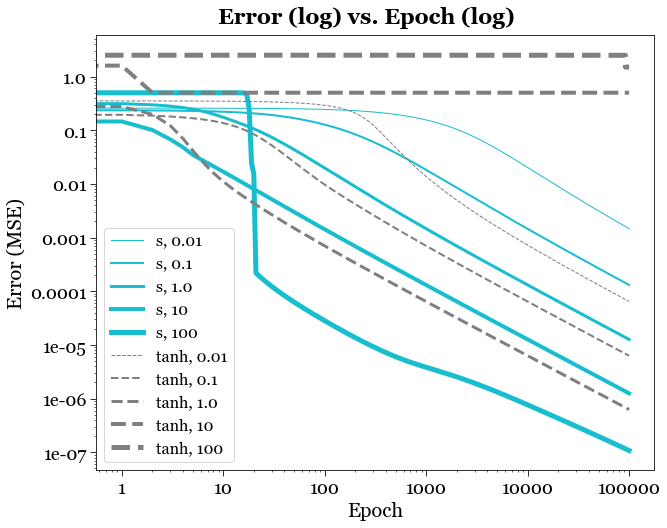

In [162]:
# plot cost w.r.t. epoch number
tanh_flag_str = ['s', 'tanh']
tanh_flag_style = ['-', '--']
tanh_flag_color = [tableau_colors[9], tableau_colors[7]]

fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

# 0 is sigmoid
for i, tanh_flag in enumerate(tanh_flags):
    for j, learning_rate in enumerate(learning_rates):
        ax.loglog(costs[i][j], label=tanh_flag_str[tanh_flag] + ', ' + str(learning_rate), \
                  linestyle=tanh_flag_style[tanh_flag], linewidth=j+1, \
                  color=tanh_flag_color[tanh_flag])


# Customize tick sizes
ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))


# Customize the plot (optional)
plt.xlabel('Epoch', fontdict=font)
plt.ylabel('Error (MSE)', fontdict=font)
plt.gcf().set_facecolor('white')
fig.suptitle('Error (log) vs. Epoch (log)', fontproperties=suptitle_font, y=0.93)
# plt.xticks(x, categories)
plt.legend(loc='lower left', prop=legend_font)

# Show the plot
plt.savefig('./plots/cost_vs_epoch.png')
plt.show()

In [168]:
y_best_pred_sigmoid, cost_best_sigmoid = test_perceptron(X_test, y_test, weights[0][4], tanh_flag=0)
y_best_pred_tanh, cost_best_tanh = test_perceptron(X_test, y_test, weights[1][2], tanh_flag=1)
print(y_test)
print(y_best_pred_sigmoid) 
print(y_best_pred_tanh)

[0 0 1 1]
[0.5        0.40147217 0.9999999  0.99999986]
[ 0.00000000e+00 -5.01383257e-11  9.98880666e-01  9.98880666e-01]


In [174]:
x_inds = list(range(1, len(y_test) + 1))
# plotting longevity against filling factors
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

# Create a side-by-side bar chart
ax.scatter(init_filling_factors, avg_generations, \
            marker='o', color=tableau_colors[0], s=20, \
            alpha=1)

# Customize tick sizes
ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
# ax.set_ylim(0, 750)
ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

# Customize the plot (optional)
plt.xlabel('Filling Factor', fontdict=font)
plt.ylabel('Number of Generations', fontdict=font)
plt.gcf().set_facecolor('white')
fig.suptitle('Long-term Stability vs. Initial Filling Factor', fontproperties=suptitle_font, y=0.93)
# plt.xticks(x, categories)
# plt.legend(loc='upper right', prop=legend_font)

# Show the plot
plt.savefig('./plots/performa.png')
plt.show()

In [165]:
# apply this to XOR function, should not work
X_XOR_test = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0]])
y_XOR_test = np.array([0, 1, 1, 0])
y_XOR_pred_tanh, cost_XOR_tanh = test_perceptron(X_XOR_test, y_XOR_test, weights[1][0], tanh_flag=1)
y_XOR_pred_sigmoid, cost_XOR_sigmoid = test_perceptron(X_XOR_test, y_XOR_test, weights[0][0], tanh_flag=0)
print(y_pred_tanh)
print(y_pred_sigmoid)
print("One can see that neither transfer function yields the right result for XOR.")

[ 0.00000000e+00 -5.27612287e-07  9.88635050e-01  9.88635038e-01]
[0.5        0.44187996 0.99848936 0.99809274]
One can see that neither transfer function yields the right result for XOR.


In [ ]:
# plot test case performances with optimized learning rates



## Double-layer Perceptron for XOR Logic